This notebook contains tools to map, plot and extract GPM IMERG precipitation data.
To run the notebook, the below libraries need to be installed once.
Edit the paths/file names for the required input data.
Set the start and end dates; and Lat.long. for location of interest.
Then, you can use the tools to map, plot and extract the data.

In [ ]:
!pip install geopandas
!pip install pandas
!pip install matplotlib
!pip install xarray
!pip install xagg
!pip install rioxarray
!pip install numpy
!pip install cartopy
!pip install netCDF4
!pip install rasterio

In [1]:
# Path to the netCDF file - Update this to the correct file path.
#nc_input_file = 'C:/Users/rbeig/Desktop/NASA/NASA_Team_Meetings/WR/Portal_Code/Code_Output/GPM_Precip_Data/Merged/Merged_GPM_precip_IMERGDFv07_2018091020180920.nc'
nc_input_file = 'C:/Users/rbeig/Desktop/NASA/NASA_Team_Meetings/WR/Portal_Code/Code_Output/GPM_Precip_Data/Master/Merged_GPM_IMERGDFv07_20010101-20230831_060724.nc'

# Path to the shapefile - Update this to the correct file path.
boundaries_path ='C:/Users/rbeig/Desktop/NASA/NASA_Team_Meetings/WR/Portal_Code/NC_Data/NC_Counties.shp'

# Output directory to store geotiffs and csv files
output_path = 'C:/Users/rbeig/Desktop/NASA/NASA_Team_Meetings/WR/Portal_Code/Code_Output/GPM_Precip_Data/Output' 

## Replace with your start date in YYYY-MM-DD format
start_date = '2018-09-14'
end_date =  '2018-09-16'

# Specific latitude coordinate for a location of interest
latitude = 34.549 

# Specific longitude coordinate for a location of interest
longitude = -77.923  


**Map_GPM_Precip_nc_NCco**

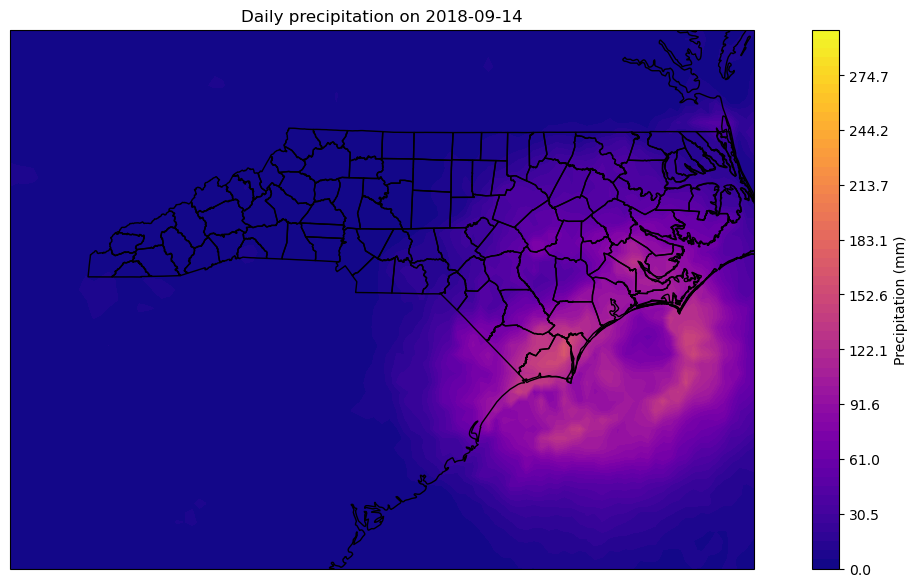

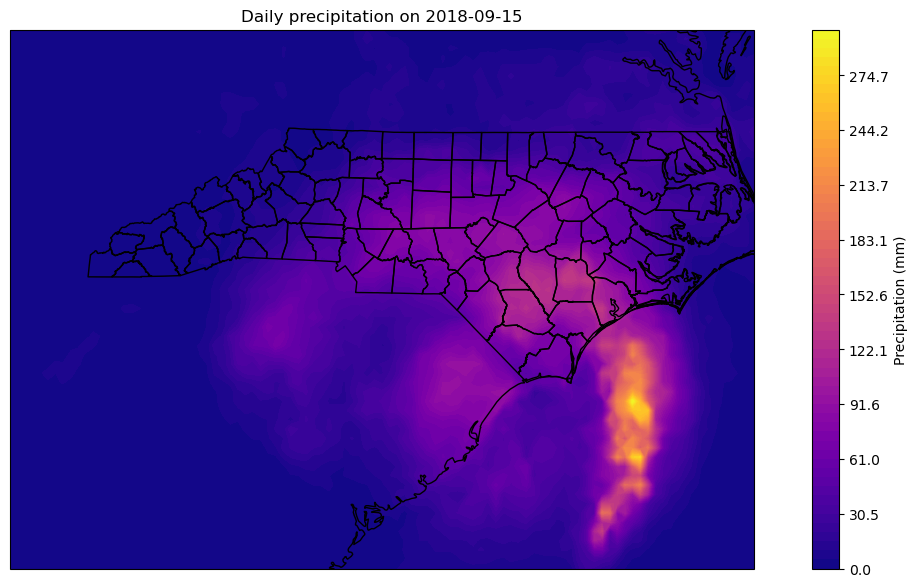

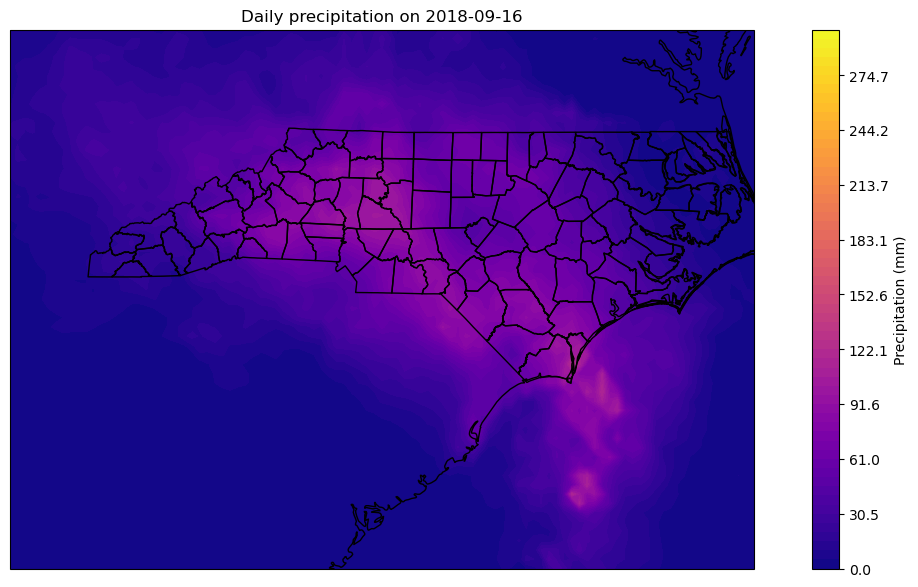

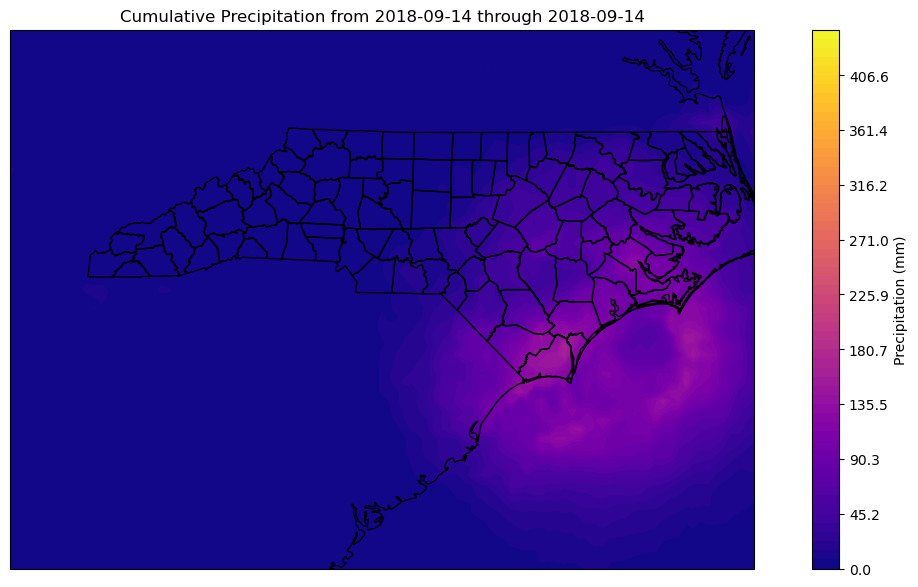

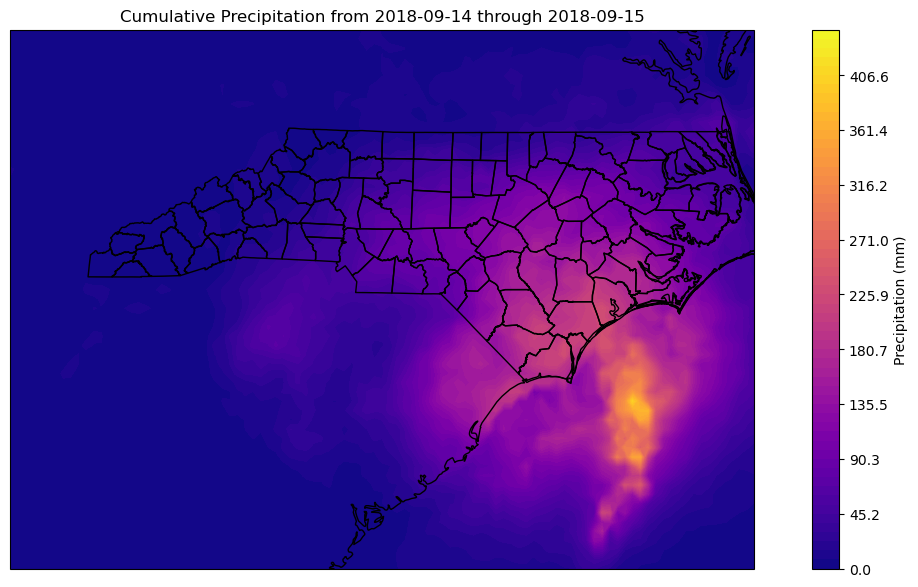

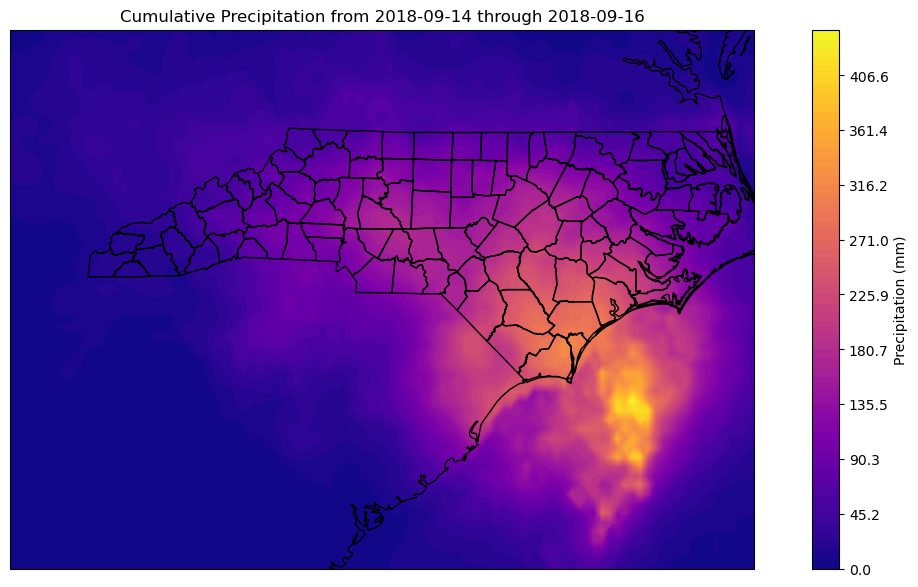

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def read_nc_file(file_path, variable_name='precipitation'):
    dataset = nc.Dataset(file_path)
    data = dataset.variables[variable_name][:]
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:]
    time = nc.num2date(dataset.variables['time'][:], units=dataset.variables['time'].units)
    
    # Sorting time and corresponding data array
    sorted_indices = np.argsort(time)
    time = time[sorted_indices]
    data = data[sorted_indices, ...]  # Ensure data array matches sorted time indices
    
    return data, lat, lon, time

def find_start_index(time_array, target_date):
    # Find the index for the first date on or after the target date
    mask = time_array >= target_date
    valid_indices = np.where(mask)[0]
    if valid_indices.size > 0:
        return valid_indices[0]
    return None  # Return None if no valid date is found

def find_end_index(time_array, target_date):
    # Find the index for the last date on or before the target date
    mask = time_array <= target_date
    valid_indices = np.where(mask)[0]
    if valid_indices.size > 0:
        return valid_indices[-1]
    return None  # Return None if no valid date is found

def get_cumulative_precip_range(data, start_index, end_index):
    cumulative_precip = np.zeros_like(data[0])
    for day in range(start_index, end_index + 1):
        cumulative_precip += data[day]
    return 0, np.max(cumulative_precip)   

def plot_data(data, lat, lon, title, global_min, global_max, boundaries_path, color_map='plasma', save_path=None):
    county_boundaries = gpd.read_file(boundaries_path)
    plt.figure(figsize=(15, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([min(lon), max(lon), min(lat), max(lat)], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, color='lightgrey')
    ax.coastlines()
    plt.contourf(lon, lat, data, levels=np.linspace(global_min, global_max, 60), transform=ccrs.PlateCarree(), cmap=color_map)
    plt.colorbar(label='Precipitation (mm)')
    plt.title(title)
    county_boundaries.boundary.plot(ax=ax, edgecolor='black', linewidth=1, facecolor='none')
    if save_path:  # Corrected the condition to check if 'save_path' is not None
        plt.savefig(save_path)
    plt.show()


def process_data(file_path, start_date, end_date, boundaries_path, variable_name='precipitation'):
    data, lat, lon, time = read_nc_file(file_path, variable_name)
    
    # Convert start_date and end_date from string to datetime
    start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
    
    start_index = find_start_index(time, start_date_dt)
    end_index = find_end_index(time, end_date_dt)
    
    data, lat, lon, time = read_nc_file(file_path, variable_name)
    start_index = find_start_index(time, datetime.strptime(start_date, '%Y-%m-%d'))
    end_index = find_end_index(time, datetime.strptime(end_date, '%Y-%m-%d'))

    if start_index is None or end_index is None:
        print("Suitable dates within the range not found in the dataset. Exiting.")
        return  # Exit if suitable dates are not found

    data_min, data_max = np.min(data[start_index:end_index + 1]), np.max(data[start_index:end_index + 1])
    for day in range(start_index, end_index + 1):
        plot_data(data[day], lat, lon, f'Daily precipitation on {time[day].strftime("%Y-%m-%d")}', data_min, data_max, boundaries_path)



    if start_index is None or end_index is None:
        print("Suitable dates within the range not found in the dataset. Exiting.")
        return  # Exit if suitable dates are not found

    data_min, data_max = np.min(data[start_index:end_index + 1]), np.max(data[start_index:end_index + 1])
    cumulative_precip = np.zeros_like(data[0])
    cumulative_min, cumulative_max = get_cumulative_precip_range(data, start_index, end_index)

    for day in range(start_index, end_index + 1):
        title = f'Cumulative Precipitation from {start_date_dt.strftime("%Y-%m-%d")} through {time[day].strftime("%Y-%m-%d")}'
        cumulative_precip += data[day]
        plot_data(cumulative_precip, lat, lon, title, cumulative_min, cumulative_max, boundaries_path)

process_data(nc_input_file, start_date, end_date, boundaries_path)


**Plot_GPM_Precip_nc**

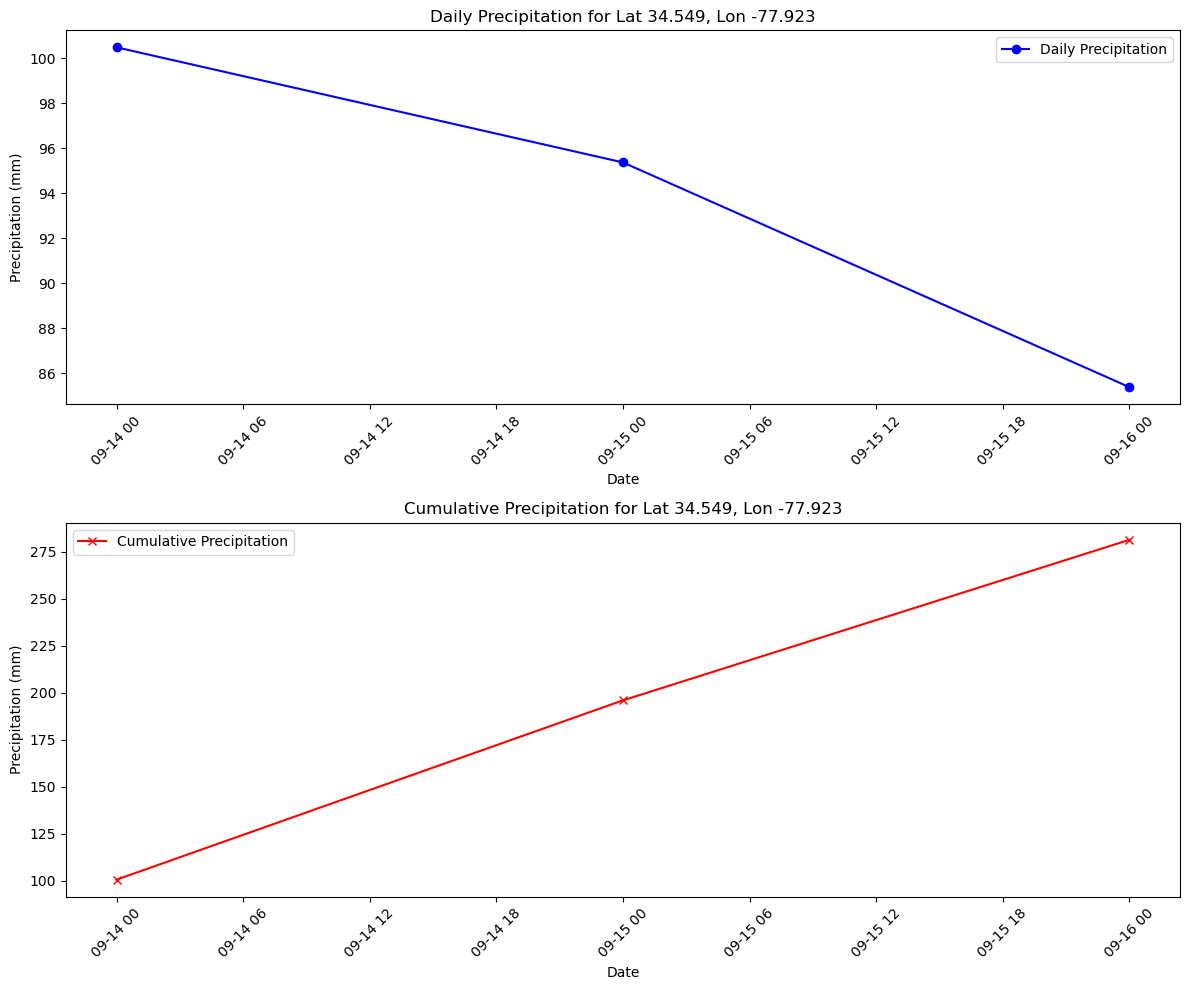

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import datetime

def load_data(nc_input_file):
    """
    Load the NetCDF data file.
    """
    return nc.Dataset(nc_input_file, mode='r')

def extract_precipitation_data(nc_data, lat, lon, time_var='time', lat_var='lat', lon_var='lon', precip_var='precipitation'):
    """
    Extract precipitation data for a specific latitude and longitude.
    """
    # Find the nearest index for the given latitude and longitude
    lat_idx = np.abs(nc_data.variables[lat_var][:] - lat).argmin()
    lon_idx = np.abs(nc_data.variables[lon_var][:] - lon).argmin()

    # Extract the time and precipitation data
    time_data = nc.num2date(nc_data.variables[time_var][:], nc_data.variables[time_var].units)
    
    # Convert time_data to standard datetime objects
    standard_time_data = [pd.to_datetime(str(date)) for date in time_data]
    
    precip_data = nc_data.variables[precip_var][:, lat_idx, lon_idx]

    return pd.Series(precip_data, index=standard_time_data)


def filter_by_date_range(series, start_date, end_date):
    """
    Filter data by a specific date range.
    """
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    return series[(series.index >= start_date) & (series.index <= end_date)]

def plot_time_series(series, lat, lon, ylabel='Precipitation (mm)'):
    """
    Plot separate time series graphs for daily and cumulative precipitation.
    """
    # Check if the Series is empty
    if series.empty:
        print(f"No precipitation data available for the specified location and date range.")
        return

    # Calculate cumulative precipitation
    cumulative_precip = series.cumsum()

    # Setting up the figure and axes for subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Daily precipitation plot
    ax1.plot(series.index, series.values, marker='o', color='blue', label='Daily Precipitation')
    ax1.set_xlabel('Date')
    ax1.set_ylabel(ylabel)
    ax1.set_title(f'Daily Precipitation for Lat {lat}, Lon {lon}')
    ax1.legend()
    ax1.tick_params(axis='x', rotation=45)

    # Cumulative precipitation plot
    ax2.plot(cumulative_precip.index, cumulative_precip.values, marker='x', color='red', label='Cumulative Precipitation')
    ax2.set_xlabel('Date')
    ax2.set_ylabel(ylabel)
    ax2.set_title(f'Cumulative Precipitation for Lat {lat}, Lon {lon}')
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)

    # Adjust layout
    plt.tight_layout()
    
    # Display the plots
    plt.show()

startdate_cell =  start_date  # Replace with your start date in YYYY-MM-DD format
enddate_cell = end_date # Replace with your end date in YYYY-MM-DD format

# Load and process data
nc_data = load_data(nc_input_file)
precip_data = extract_precipitation_data(nc_data, latitude, longitude)
filtered_data = filter_by_date_range(precip_data, startdate_cell , enddate_cell)

# Plotting
plot_time_series(filtered_data, latitude, longitude)



**Get_GPM_Precip_nc**

In [12]:
import os
import pandas as pd
import numpy as np
import netCDF4 as nc
import datetime
import re

def load_data(nc_path):
    """
    Load the NetCDF data file.
    """
    return nc.Dataset(nc_path, mode='r')

def extract_precipitation_data(nc_data, lat, lon, time_var='time', lat_var='lat', lon_var='lon', precip_var='precipitation'):
    """
    Extract precipitation data for a specific latitude and longitude.
    """
    lat_idx = np.abs(nc_data.variables[lat_var][:] - lat).argmin()
    lon_idx = np.abs(nc_data.variables[lon_var][:] - lon).argmin()
    time_data = nc.num2date(nc_data.variables[time_var][:], nc_data.variables[time_var].units)
    standard_time_data = [pd.to_datetime(str(date)) for date in time_data]
    precip_data = nc_data.variables[precip_var][:, lat_idx, lon_idx]
    df = pd.DataFrame({
        'Date': standard_time_data,
        'Precipitation': precip_data,
        'LatLon': f"{latitude} {longitude}"
    })
    df.set_index('Date', inplace=True)
    return df

def filter_by_date_range(df, start_date1, end_date1):
    start_date2 = pd.to_datetime(start_date1)
    end_date2 = pd.to_datetime(end_date1)
    return df[(df.index >= start_date2) & (df.index <= end_date2)]

def pivot_data(df):
    return df.pivot_table(index='LatLon', columns='Date', values='Precipitation')

def save_data_to_csv(df, file_path):
    #df.to_csv(file_path, header=['Date', 'Precipitation', 'LatLon'])
    df.to_csv(file_path)

#startdate_cell =  Start_Date  # Replace with your start date in YYYY-MM-DD format
#enddate_cell = End_Date # Replace with your end date in YYYY-MM-DD format

if not os.path.exists(output_path):
    os.makedirs(output_path, exist_ok=True)

# Extract the last numeric range before '.nc' to use in the output filename
date_match = re.search(r'(\d+)(?=\D*\.nc)', nc_input_file)
if date_match:
    number_prefix = date_match.group(1)
    output_filename = f"Get_GPM_IMERFv07_LatLong_{number_prefix}_{start_date}_{end_date}.csv"
    full_output_path = os.path.join(output_path, output_filename)
else:
    raise ValueError("Filename does not contain a valid date range identifier")

# Load and process data
nc_data = load_data(nc_input_file)
precip_df = extract_precipitation_data(nc_data, latitude, longitude)
filtered_df = filter_by_date_range(precip_df, start_date, end_date)
pivoted_df = pivot_data(filtered_df)

# Save filtered and pivoted data to CSV
save_data_to_csv(pivoted_df, full_output_path)
print(f"Data saved to {full_output_path}")


Data saved to C:/Users/rbeig/Desktop/NASA/NASA_Team_Meetings/WR/Portal_Code/Code_Output/GPM_Precip_Data/Output\Get_GPM_IMERFv07_LatLong_2018091020180920_2018-09-14_2018-09-16.csv


**Map_GPM_Grid_Precip_Geotiff**

In [13]:
import netCDF4 as nc
import numpy as np
import rasterio
from rasterio.transform import from_origin
from datetime import datetime
import os  # To handle file path operations

def read_nc_file(file_path):
    dataset = nc.Dataset(file_path)
    precipitation = dataset.variables['precipitation'][:]
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:]
    time = nc.num2date(dataset.variables['time'][:], units=dataset.variables['time'].units)
    sorted_indices = np.argsort(time)
    time = time[sorted_indices]
    precipitation = precipitation[sorted_indices, ...]
    return precipitation, lat, lon, time

def find_time_index(time_array, target_date):
    return np.argmin(np.abs(time_array - target_date))

def save_as_geotiff(data, lat, lon, save_path):
    resolution = lat[1] - lat[0]
    transform = from_origin(lon.min(), lat.max(), resolution, resolution)
    with rasterio.open(
        save_path,
        'w',
        driver='GTiff',
        height=data.shape[0],
        width=data.shape[1],
        count=1,
        dtype=str(data.dtype),
        crs='+proj=latlong',
        transform=transform
    ) as dst:
        dst.write(data, 1)

def process_precipitation(file_path, start_date, end_date, output_path):
    precip, lat, lon, time = read_nc_file(file_path)
    start_index = find_time_index(time, start_date)
    end_index = find_time_index(time, end_date)
    os.makedirs(output_path, exist_ok=True)  # Ensure the output directory exists

    for day in range(start_index, end_index + 1):
        daily_file_path = os.path.join(output_path, f'GPM_Precip_IMERGFv07_{time[day].strftime("%Y%m%d")}.tif')
        save_as_geotiff(precip[day], lat, lon, daily_file_path)

    cumulative_precip = np.zeros_like(precip[0])
    for day in range(start_index, end_index + 1):
        cumulative_precip += precip[day]

    cumulative_file_path = os.path.join(output_path, f'cum_GPM_Precip_IMERGFv07_{start_date.strftime("%Y%m%d")}_through_{end_date.strftime("%Y%m%d")}.tif')
    save_as_geotiff(cumulative_precip, lat, lon, cumulative_file_path)

startdate_cell = datetime.strptime(start_date , '%Y-%m-%d')
enddate_cell = datetime.strptime(end_date, '%Y-%m-%d')

process_precipitation(nc_input_file, startdate_cell, enddate_cell, output_path)
